In [1]:
import numpy as np
import pandas as pd
import keras
from PIL import Image

C:\Users\Edu\Anaconda3\envs\neuronales\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
archivo_labels = pd.read_csv("labels_train.csv", error_bad_lines=False, engine='python')
archivo_labels.dropna(inplace=True)

In [3]:
count = archivo_labels.loc[:,['count']].to_dict()['count']
ids = archivo_labels.loc[:,['id']].to_dict()['id']

In [4]:
def generar_npy():
    for key in ids:
        file_name = ids[key]
        path = ""
        if file_name < 1000:
            path = "frames_train/seq_000" + str(file_name) + ".jpg"
        else:
            path = "frames_train/seq_00" + str(file_name) + ".jpg"
        img = Image.open(path)
        img = img.resize((160,120))
        arr = np.asarray(img)
        np.save("data_train/"+str(key)+".npy", arr)
    

In [5]:
labels = archivo_labels.loc[:,['count']].to_dict()['count']
indices = np.arange(len(labels))
np.random.shuffle(indices)
split = int(len(indices)*0.8)
partition = {
    'train':indices[:split].tolist(),
    'validation':indices[split:].tolist(),
}

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv1D, SpatialDropout2D
from keras.layers import Input

### Autoencoder

> Se utiliza un autoencoder que se encargue de determinar dónde se encuentra la gente dentro de las imagenes. Se basa sobre la idea de que al estar todas las imagenes en la misma ubicación física, el espacio latente podrá almacenar este espacio común.
Luego esta información se utilizará con respecto a los inputs para encontrar dónde están las personas.

In [209]:
model = Sequential()
model.add(Conv2D(16, (12, 12), activation='relu', padding='same', input_shape=(120,160,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(8, (12, 12), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(4, (12, 12), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(4, (12, 12), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
#model.add(Conv2D(8, (12, 12), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (12, 12), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (12, 12), activation='sigmoid', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 120, 160, 16)      6928      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 60, 80, 16)        36880     
_________________________________________________________________
up_sampling2d_60 (UpSampling (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 120, 160, 3)       6915      
Total params: 50,723
Trainable params: 50,723
Non-trainable params: 0
_________________________________________________________________


In [210]:
model.compile(optimizer='adam',loss='binary_crossentropy')

> Utilizando como objetivo una imagen distinta terminará por obtener el espacio latente de las zonas en común de los frames.

In [211]:
def generator_first(features, dim, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features1 = np.zeros((batch_size, *dim))
    batch_features2 = np.zeros((batch_size, *dim))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index1 = np.asscalar(np.random.choice(len(features),1))
            index2 = np.asscalar(np.random.choice(len(features),1))
            batch_features1[i] = np.load("data_train/"+str(index1)+".npy") / 255.0
            batch_features2[i] = np.load("data_train/"+str(index2)+".npy") / 255.0
        yield batch_features1, batch_features2

In [237]:
batch_size = 8
asd = model.fit_generator(generator=generator_first(partition['train'], (120,160,3), batch_size),
                    validation_data=generator_first(partition['validation'], (120,160,3), batch_size),
                    steps_per_epoch=int(len(partition['train'])/batch_size),
                    validation_steps=int(len(partition['validation'])/batch_size),
                    epochs=35, verbose=1)

Epoch 1/10
160/160 [==============================] - 19s 116ms/step - loss: 0.6142 - val_loss: 0.6114
Epoch 2/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6140 - val_loss: 0.6119
Epoch 3/10
160/160 [==============================] - 18s 114ms/step - loss: 0.6138 - val_loss: 0.6119
Epoch 4/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6137 - val_loss: 0.6114
Epoch 5/10
160/160 [==============================] - 18s 115ms/step - loss: 0.6141 - val_loss: 0.6117
Epoch 6/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6141 - val_loss: 0.6123
Epoch 7/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6137 - val_loss: 0.6121
Epoch 8/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6136 - val_loss: 0.6113
Epoch 9/10
160/160 [==============================] - 18s 113ms/step - loss: 0.6139 - val_loss: 0.6161
Epoch 10/10
160/160 [==============================] - 18s 113ms/step - l

In [213]:
import matplotlib.pyplot as plt

In [214]:
img_testeo = np.load("data_train/"+str(1000)+".npy")

In [92]:
def densidad(img):
    pred = model.predict(np.expand_dims(img / 255.0, axis=0))
    pred = np.squeeze(pred, axis=0)
    img2 = np.absolute((pred*255).astype(int)-img)
    return np.dot(img2[...,:3], [0.299, 0.587, 0.114])

> Este es el resultado del enfoque anterior, es apreciable que se elimaron las personas y sólo se obtuvo el pasillo.
Una vez se hace la diferencia entre la imagen original y la del pasillo quedan las personas.

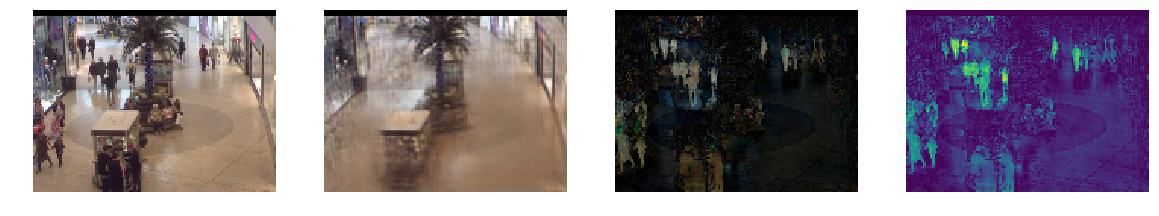

In [256]:
pred1 = model.predict(np.expand_dims(img_testeo / 255.0, axis=0))
pred1 = np.squeeze(pred1, axis=0)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)
fig=plt.figure()

fig.add_subplot(1, 4, 1)
plt.imshow(img_testeo)
plt.axis('off')

fig.add_subplot(1, 4, 2)
plt.imshow(pred1)
plt.axis('off')

fig.add_subplot(1, 4, 3)
plt.imshow(np.absolute(pred1-img_testeo/255))
plt.axis('off')

fig.add_subplot(1, 4, 4)
plt.imshow(np.dot(np.absolute(pred1-img_testeo/255)[...,:3], [0.299, 0.587, 0.114]))
plt.axis('off')

plt.show()

> Ahora se entrena una red que se encargue de contar las personas en las imágenes filtradas (como las últimas dos del ejemplo anterior).

In [245]:
model2 = Sequential()
model2.add(Conv2D(32, (12,12), padding='same', input_shape=(120,160,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(SpatialDropout2D(0.25))
model2.add(Conv2D(64, (12,12), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(SpatialDropout2D(0.25))
model2.add(Conv2D(128, (12,12), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dense(1))
model2.add(Activation('relu'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 120, 160, 32)      13856     
_________________________________________________________________
activation_6 (Activation)    (None, 120, 160, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 120, 160, 32)      128       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 60, 80, 32)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 80, 64)        294976    
_________________________________________________________________
activation_7 (Activation)    (None, 60, 80, 64)        0         
__________

In [247]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [248]:
model2.compile(optimizer='adam',loss=root_mean_squared_error)

> Este generador de _batches_ se encarga de obtener las imágenes filtradas y pasarlas a la red.

In [251]:
def generator2(features, labels, dim, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, *dim))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.asscalar(np.random.choice(len(features),1))
            img = np.load("data_train/"+str(index)+".npy") / 255.0
            pred = model.predict(np.expand_dims(img, axis=0))
            pred = np.squeeze(pred, axis=0)
            
            batch_features[i] = np.absolute(pred-img)
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

In [252]:
batch_size = 8
asd2 = model2.fit_generator(generator=generator2(partition['train'], labels, (120,160,3), batch_size),
                    validation_data=generator2(partition['validation'], labels, (120,160,3), batch_size),
                    steps_per_epoch=int(len(partition['train'])/batch_size),
                    validation_steps=int(len(partition['validation'])/batch_size),
                    epochs=20, verbose=1) #15

Epoch 1/20
160/160 [==============================] - 42s 260ms/step - loss: 13.1310 - val_loss: 9.7704
Epoch 2/20
160/160 [==============================] - 41s 256ms/step - loss: 10.2006 - val_loss: 5.0991
Epoch 3/20
160/160 [==============================] - 41s 257ms/step - loss: 5.8107 - val_loss: 7.4603
Epoch 4/20
160/160 [==============================] - 41s 259ms/step - loss: 4.9025 - val_loss: 9.3681
Epoch 5/20
160/160 [==============================] - 41s 256ms/step - loss: 4.8045 - val_loss: 4.1068
Epoch 6/20
160/160 [==============================] - 41s 255ms/step - loss: 4.4040 - val_loss: 5.2393
Epoch 7/20
160/160 [==============================] - 42s 260ms/step - loss: 4.5458 - val_loss: 5.1846
Epoch 8/20
160/160 [==============================] - 41s 255ms/step - loss: 4.3430 - val_loss: 4.2457
Epoch 9/20
160/160 [==============================] - 41s 255ms/step - loss: 4.2687 - val_loss: 6.6742
Epoch 10/20
160/160 [==============================] - 41s 258ms/step -

In [ ]:
def generar_npy():
    for key in ids:
        file_name = ids[key]
        path = ""
        if file_name < 1000:
            path = "frames_test/seq_000" + str(file_name) + ".jpg"
        else:
            path = "frames_test/seq_00" + str(file_name) + ".jpg"
        img = Image.open(path)
        img = img.resize((160,120))
        arr = np.asarray(img)
        np.save("data_train/"+str(key)+".npy", arr)